# Model Analysis

In this notebook, we analyze and evaluate the three trained models: Multinomial Naive Bayes, Logistic Regression, and LDA-based Classifier.

## Inputs
- `preprocessing_outputs/features/X_tfidf.npz` – TF-IDF matrix
- `preprocessing_outputs/features/y.npy` – Binary labels
- `preprocessing_outputs/conda_cleaned_binary_without_chat.csv` – Cleaned text data for LDA
- `model_outputs/naive_bayes_model.joblib` – trained Multinomial Naive Bayes
- `model_outputs/logistic_regression_model.joblib` – trained Logistic Regression
- `model_outputs/lda_model.joblib` – trained LDA model
- `model_outputs/lda_count_vectorizer.joblib` – Count vectorizer for LDA
- `model_outputs/lda_lr_classifier.joblib` – LDA-based classifier

## Outputs
- `analysis_outputs/reports/model_comparison.csv` – performance metrics for all models
- `analysis_outputs/reports/classification_report_nb.txt` – detailed metrics for Naive Bayes
- `analysis_outputs/reports/classification_report_lr.txt` – detailed metrics for Logistic Regression
- `analysis_outputs/reports/classification_report_lda.txt` – detailed metrics for LDA-based Classifier
- `analysis_outputs/plots/confusion_matrices.png` – confusion matrix heatmaps for all models
- `analysis_outputs/plots/roc_curves.png` – ROC curves for all models
- `analysis_outputs/plots/model_comparison.png` – bar chart comparing metrics


## 0) Directory Paths


In [1]:
# Preprocessing input paths
PREPROCESSING_DIR = "../without_chat_time/preprocessing_outputs"
FEATURES_DIR      = f"{PREPROCESSING_DIR}/features"

# Model input paths
MODELS_DIR    = "../without_chat_time/model_outputs"

# Analysis output paths (reports and plots go here)
OUTPUT_DIR    = "../without_chat_time/analysis_outputs"
REPORTS_DIR   = f"{OUTPUT_DIR}/reports"
PLOTS_DIR     = f"{OUTPUT_DIR}/plots"

import os
for d in [OUTPUT_DIR, MODELS_DIR, REPORTS_DIR, PLOTS_DIR]:
    os.makedirs(d, exist_ok=True)


## 1) Import Statements


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from joblib import load

# Scikit-learn library imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)

RANDOM_STATE = hash("I love MAXXXXXXX!") % (2**32)
np.random.seed(RANDOM_STATE)


## 2) Load Preprocessed Data


In [3]:
# Load TF-IDF features (sparse matrix)
X = sparse.load_npz(f"{FEATURES_DIR}/X_tfidf.npz")
print(f"Loaded TF-IDF features shape: {X.shape}")

# Load labels
y = np.load(f"{FEATURES_DIR}/y.npy")
print(f"Loaded labels shape: {y.shape}")

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print(f"\nClass distribution:")
for label, count in zip(unique, counts):
    class_name = "Toxic" if label == 1 else "Non-Toxic"
    percentage = (count / len(y)) * 100
    print(f"  {class_name} ({label}): {count} samples ({percentage:.1f}%)")


Loaded TF-IDF features shape: (26914, 6171)
Loaded labels shape: (26914,)

Class distribution:
  Non-Toxic (0): 21694 samples (80.6%)
  Toxic (1): 5220 samples (19.4%)


## 3) Train-Test Split Again


In [4]:
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 21531 samples
Testing set size: 5383 samples


## 4) Load Supervised Trained Models


In [5]:
# Load trained models
nb_model = load(f"{MODELS_DIR}/naive_bayes_model.joblib")
lr_model = load(f"{MODELS_DIR}/logistic_regression_model.joblib")



## 5) Generate Predictions


In [6]:
y_pred_nb = nb_model.predict(X_test)
y_pred_proba_nb = nb_model.predict_proba(X_test)

y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)



## 6) Load LDA Model + New Generate Predictions


In [7]:
# Load cleaned text data for LDA
df_cleaned = pd.read_csv(f"{PREPROCESSING_DIR}/conda_cleaned_binary_without_chat_time.csv")
texts = df_cleaned['utterance_cleaned'].fillna('').astype(str).tolist()

texts_train, texts_test = train_test_split(
    texts,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# Load LDA model + vectorizer
lda_model = load(f"{MODELS_DIR}/lda_model.joblib")
count_vectorizer = load(f"{MODELS_DIR}/lda_count_vectorizer.joblib")
lda_lr_model = load(f"{MODELS_DIR}/lda_lr_classifier.joblib")

# Transform texts to count matrix + get topic distributions
X_count_test = count_vectorizer.transform(texts_test)
doc_topic_dist_test = lda_model.transform(X_count_test)

# Generate predictions from LDA-based classifier
y_pred_lda = lda_lr_model.predict(doc_topic_dist_test)
y_pred_proba_lda = lda_lr_model.predict_proba(doc_topic_dist_test)


# Display top words for each topic
feature_names = count_vectorizer.get_feature_names_out()
n_top_words = 10
print(f"\nTop {n_top_words} words per topic:")
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[-n_top_words:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {' '.join(top_words)}")



Top 10 words per topic:
Topic 1: ggwp xd good hahaha game like report plz idiot guy
Topic 2: haha fuck game ok go get ur bad play come
Topic 3: gg ez mid kill shit time rofl lmao yes w8
Topic 4: nice end ty noob wait im wtf commend fucking yeah
Topic 5: lol wp report pls sf team sad please pudge dont


/opt/anaconda3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/ml_project/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## 7) Evaluate Models ##

In [8]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])

    print(f"{model_name} Evaluation Results")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Now we need to call evaluate_model() to evaluate all three models
nb_metrics = evaluate_model(y_test, y_pred_nb, y_pred_proba_nb, "Multinomial Naive Bayes")
lr_metrics = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression")
lda_metrics = evaluate_model(y_test, y_pred_lda, y_pred_proba_lda, "LDA-based Classifier")


Multinomial Naive Bayes Evaluation Results
Accuracy:  0.9289
Precision: 0.9320
Recall:    0.9289
F1-Score:  0.9232
ROC-AUC:   0.9478
Logistic Regression Evaluation Results
Accuracy:  0.9348
Precision: 0.9367
Recall:    0.9348
F1-Score:  0.9304
ROC-AUC:   0.9663
LDA-based Classifier Evaluation Results
Accuracy:  0.8061
Precision: 0.6497
Recall:    0.8061
F1-Score:  0.7195
ROC-AUC:   0.6187


## **8) Classification Reports**


In [9]:
# Generate detailed classification reports
print("Multinomial Naive Bayes - Detailed Statistics")
nb_report = classification_report(
    y_test, y_pred_nb,
    target_names=['Non-Toxic', 'Toxic'],
    digits=4
)
print(nb_report)

# Save as a file
with open(f"{REPORTS_DIR}/classification_report_nb.txt", 'w') as f:
    f.write("Multinomial Naive Bayes - Statistics Report\n")
    f.write(nb_report)

print("Logistic Regression - Detailed Statistics")
lr_report = classification_report(
    y_test, y_pred_lr,
    target_names=['Non-Toxic', 'Toxic'],
    digits=4
)
print(lr_report)

with open(f"{REPORTS_DIR}/classification_report_lr.txt", 'w') as f:
    f.write("Logistic Regression - Statistics Report\n")
    f.write(lr_report)

print("LDA-based Classifier - Detailed Statistics")
lda_report = classification_report(
    y_test, y_pred_lda,
    target_names=['Non-Toxic', 'Toxic'],
    digits=4
)
print(lda_report)

with open(f"{REPORTS_DIR}/classification_report_lda.txt", 'w') as f:
    f.write("LDA-based Classifier - Statistics Report\n")
    f.write(lda_report)


Multinomial Naive Bayes - Detailed Statistics
              precision    recall  f1-score   support

   Non-Toxic     0.9225    0.9954    0.9575      4339
       Toxic     0.9715    0.6523    0.7805      1044

    accuracy                         0.9289      5383
   macro avg     0.9470    0.8238    0.8690      5383
weighted avg     0.9320    0.9289    0.9232      5383

Logistic Regression - Detailed Statistics
              precision    recall  f1-score   support

   Non-Toxic     0.9299    0.9940    0.9609      4339
       Toxic     0.9651    0.6887    0.8038      1044

    accuracy                         0.9348      5383
   macro avg     0.9475    0.8414    0.8824      5383
weighted avg     0.9367    0.9348    0.9304      5383

LDA-based Classifier - Detailed Statistics
              precision    recall  f1-score   support

   Non-Toxic     0.8061    1.0000    0.8926      4339
       Toxic     0.0000    0.0000    0.0000      1044

    accuracy                         0.8061      53

/opt/anaconda3/envs/ml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/ml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/ml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

## 9) Generate and Plot Confusion Matrices


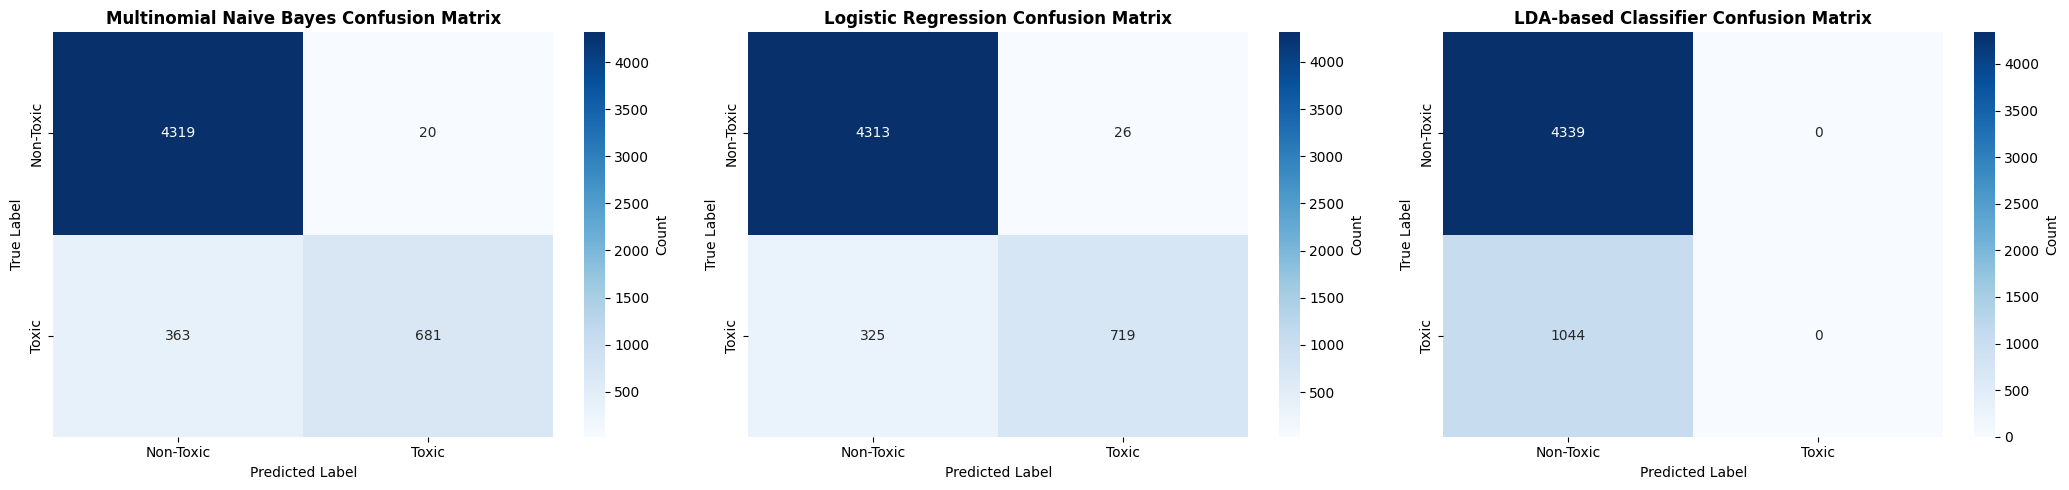

Confusion matrix plots saved to ../without_chat_time/analysis_outputs/plots/confusion_matrices.png


In [10]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lda = confusion_matrix(y_test, y_pred_lda)

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# =========== Naive Bayes confusion matrix ===========
sns.heatmap(
    cm_nb, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-Toxic', 'Toxic'],
    yticklabels=['Non-Toxic', 'Toxic'],
    ax=axes[0],
    cbar_kws={'label': 'Count'}
)
axes[0].set_title('Multinomial Naive Bayes Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# =========== Logistic Regression confusion matrix ===========
sns.heatmap(
    cm_lr, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-Toxic', 'Toxic'],
    yticklabels=['Non-Toxic', 'Toxic'],
    ax=axes[1],
    cbar_kws={'label': 'Count'}
)
axes[1].set_title('Logistic Regression Confusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# =========== LDA-based classifier confusion matrix ===========
sns.heatmap(
    cm_lda, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-Toxic', 'Toxic'],
    yticklabels=['Non-Toxic', 'Toxic'],
    ax=axes[2],
    cbar_kws={'label': 'Count'}
)
axes[2].set_title('LDA-based Classifier Confusion Matrix', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/confusion_matrices.png", dpi=200, bbox_inches='tight')
plt.show()

print(f"Confusion matrix plots saved to {PLOTS_DIR}/confusion_matrices.png")


## 10) Generate and Compare ROC Curves


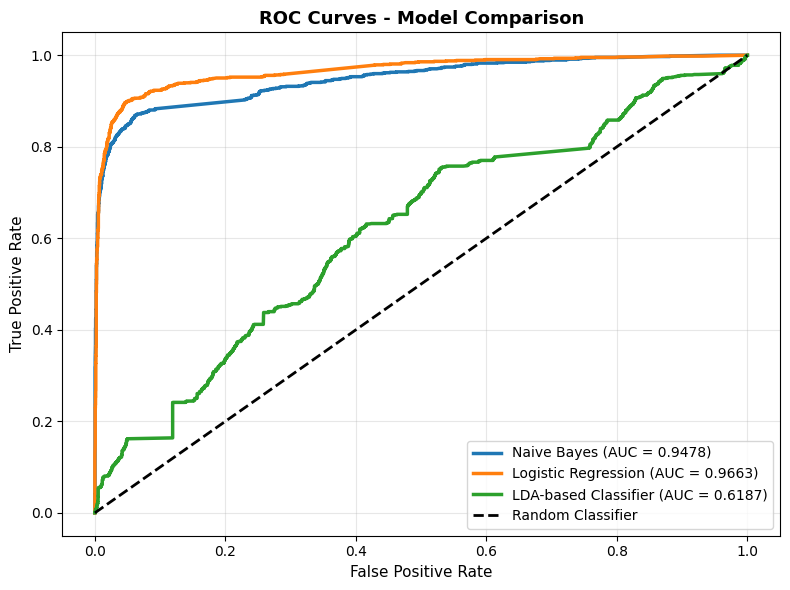

ROC curve plots saved to ../without_chat_time/analysis_outputs/plots/roc_curves.png


In [11]:
# Compute the ROC curves
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_proba_nb[:, 1])
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_lda, tpr_lda, _ = roc_curve(y_test, y_pred_proba_lda[:, 1])
roc_auc_lda = auc(fpr_lda, tpr_lda)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(
    fpr_nb, tpr_nb,
    label=f'Naive Bayes (AUC = {roc_auc_nb:.4f})',
    linewidth=2.5
)
plt.plot(
    fpr_lr, tpr_lr,
    label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})',
    linewidth=2.5
)
plt.plot(
    fpr_lda, tpr_lda,
    label=f'LDA-based Classifier (AUC = {roc_auc_lda:.4f})',
    linewidth=2.5
)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curves - Model Comparison', fontsize=13, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/roc_curves.png", dpi=200, bbox_inches='tight')
plt.show()

print(f"ROC curve plots saved to {PLOTS_DIR}/roc_curves.png")


## 11) Generalized Model Comparison (3 models)


In [12]:
comparison_df = pd.DataFrame([nb_metrics, lr_metrics, lda_metrics])
comparison_df = comparison_df.set_index('Model')

comparison_df.to_csv(f"{REPORTS_DIR}/model_comparison.csv")

print("Model Comparison Summary")
print(comparison_df.round(4))
print(f"\nComparison saved to {REPORTS_DIR}/model_comparison.csv")


Model Comparison Summary
                         Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                                  
Multinomial Naive Bayes    0.9289     0.9320  0.9289    0.9232   0.9478
Logistic Regression        0.9348     0.9367  0.9348    0.9304   0.9663
LDA-based Classifier       0.8061     0.6497  0.8061    0.7195   0.6187

Comparison saved to ../without_chat_time/analysis_outputs/reports/model_comparison.csv


## 12) **EXTRA:** Visualize Model Comparison


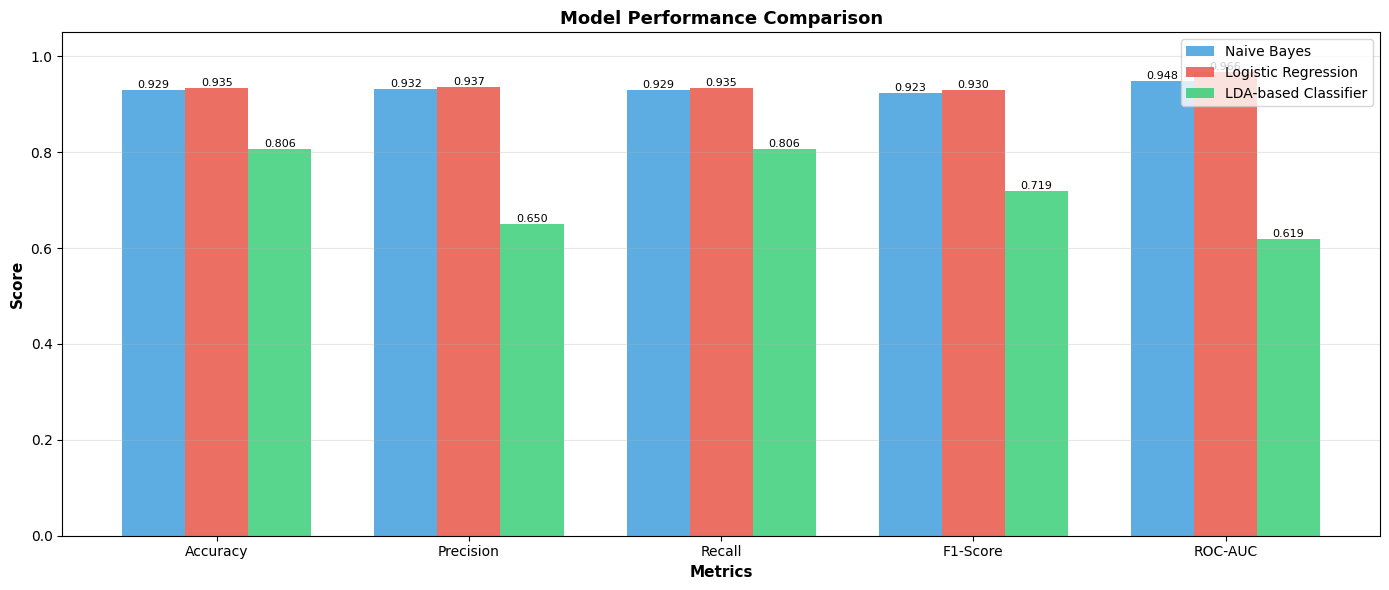

Model comparison metrics plot saved to ../without_chat_time/analysis_outputs/plots/model_comparison.png


In [13]:
# Model performance comparison bar chart!!!
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
nb_values = [nb_metrics['Accuracy'], nb_metrics['Precision'], nb_metrics['Recall'], nb_metrics['F1-Score'], nb_metrics['ROC-AUC']]
lr_values = [lr_metrics['Accuracy'], lr_metrics['Precision'], lr_metrics['Recall'], lr_metrics['F1-Score'], lr_metrics['ROC-AUC']]
lda_values = [lda_metrics['Accuracy'], lda_metrics['Precision'], lda_metrics['Recall'], lda_metrics['F1-Score'], lda_metrics['ROC-AUC']]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))

bars1 = ax.bar(x - width, nb_values, width, label='Naive Bayes', alpha=0.8, color='#3498db')
bars2 = ax.bar(x, lr_values, width, label='Logistic Regression', alpha=0.8, color='#e74c3c')
bars3 = ax.bar(x + width, lda_values, width, label='LDA-based Classifier', alpha=0.8, color='#2ecc71')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=8
        )

ax.set_xlabel('Metrics', fontsize=11, fontweight='bold')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=10)
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/model_comparison.png", dpi=200, bbox_inches='tight')
plt.show()

print(f"Model comparison metrics plot saved to {PLOTS_DIR}/model_comparison.png")


## 13) Summary and Best Model


In [14]:
print(f"\nDataset Stats:")
print(f"  Total samples: {len(y)}")
print(f"  Training samples: {len(y_train)}")
print(f"  Testing samples: {len(y_test)}")

print(f"\nModel Performance:")
print(f"  Naive Bayes - Accuracy: {nb_metrics['Accuracy']:.4f}, ROC-AUC: {nb_metrics['ROC-AUC']:.4f}")
print(f"  Logistic Regression - Accuracy: {lr_metrics['Accuracy']:.4f}, ROC-AUC: {lr_metrics['ROC-AUC']:.4f}")
print(f"  LDA-based Classifier - Accuracy: {lda_metrics['Accuracy']:.4f}, ROC-AUC: {lda_metrics['ROC-AUC']:.4f}")

# Determine best model
all_models = {
    "Naive Bayes": nb_metrics['F1-Score'],
    "Logistic Regression": lr_metrics['F1-Score'],
    "LDA-based Classifier": lda_metrics['F1-Score']
}
best_model = max(all_models, key=all_models.get)
print(f"\nOverall Best Performing Model: {best_model} has F1-Score = ({all_models[best_model]:.4f})")



Dataset Stats:
  Total samples: 26914
  Training samples: 21531
  Testing samples: 5383

Model Performance:
  Naive Bayes - Accuracy: 0.9289, ROC-AUC: 0.9478
  Logistic Regression - Accuracy: 0.9348, ROC-AUC: 0.9663
  LDA-based Classifier - Accuracy: 0.8061, ROC-AUC: 0.6187

Overall Best Performing Model: Logistic Regression has F1-Score = (0.9304)
